In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn

import sys
sys.path.append("..")
import model.resnet_cifar10 as ResNet
import argparse
import matplotlib.pyplot as plt
import os
import imageio
import shutil
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import numpy as np
import random

def savefig(name):
    plt.savefig(name,dpi=600, bbox_inches='tight')
    return

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.benchmark = True #for accelerating the running
    return

#setup_seed(1)

parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('--gpu-id', default=[0], nargs='+', type=int, help='available GPU IDs')
parser.add_argument('--epochs', default=250, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int, metavar='N', help='mini-batch size (default: 128),only used for train')
parser.add_argument('-w', '--workers', default=5, type=int, metavar='N', help='num_workers, at most 16, must be 0 on windows')
parser.add_argument('--lr', '--learning-rate', default=0.002, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-3, type=float, metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=60, type=int, metavar='N', help='print frequency (default: 10)')
#parser.add_argument('--resume', default='checkpoint/Alexnet/checkpoint.pth.tar', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('-t', '--train', dest='train', action='store_true', help='test model on test set')

args = parser.parse_known_args()[0]

Path_Name = 'Alexnet'
checkpoint_path = 'checkpoint/' + Path_Name
summary_path = 'summary/' + Path_Name
if args.train:
    if not os.path.exists(summary_path):
        os.makedirs(summary_path)
    writer = SummaryWriter(summary_path)

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# CIFAR10 dataset 
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=train_transform, download=True)

valid_dataset = torchvision.datasets.CIFAR10(root='data', train=False, transform=test_transform)

# valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, (int(0.5*len(test_dataset)), int(0.5*len(test_dataset))))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=args.batch_size)
batch_size = 200
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
all_train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=args.workers, pin_memory=True)
# model = LinearNeuralNet(input_size, 5, num_classes).to(device)
#model = AlexNet.AlexNet_0()
model = ResNet.resnet18()
#model = Vgg.VGG('VGG11')
#model = LeNet.LeNet()
#model = Googlenet.GoogLeNet()
model = nn.DataParallel(model, device_ids=args.gpu_id).cuda()
image_list = [] 
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
cudnn.benchmark = True
KS_dis = []
test_accuracy = []
best_prec = 0
mean_difference_all = []

if args.resume:
    if os.path.isfile(args.resume):
        print('=> loading checkpoint "{}"'.format(args.resume))
        checkpoint = torch.load(args.resume)
        #args.start_epoch = checkpoint['epoch']
        #best_prec = checkpoint['best_acc']
        checkpoint['state_dict']['module.classifier.bias_r'] = torch.arange(10)
        checkpoint['state_dict']['module.classifier.weight_a'] = torch.zeros(10,512,512)
        #checkpoint['state_dict']['module.classifier.bias_r'] = torch.arange(10)
        model.load_state_dict(checkpoint['state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {} best_acc {})".format(args.resume, checkpoint['epoch'], best_prec))
    else:
        print("=> no checkpoint found at '{}'".format(args.resume))

print(model.module.linear)     






for epoch in range(args.start_epoch, args.epochs):
    if epoch < 150:
        lr = args.lr
    else:
        lr = args.lr * 0.1

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    model.train()
    train_total = 0
    train_correct = 0
    train_loss = 0
    # train for one epoch
    for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        input, target = input.cuda(), target.long().cuda()

        # compute output
        output = model(input)
        loss = criterion(output, target)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        ave_loss = train_loss/(i+1)

        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

        prec = train_correct / train_total
        if (i+1) % args.print_freq == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.5f}, Train_Acc:{:.2f}%'.format(epoch+1, args.epochs, i+1, len(train_loader), loss, prec*100))


    # evaluate on test set
    # switch to evaluate mode
    model.eval()
    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        for i, (input, target) in enumerate(valid_loader):
            input, target = input.cuda(), target.long().cuda()

            #input_digit = input[target==digit,:,:,:] 
            output = model(input)

            _, predicted = torch.max(output.data, 1)
            valid_total = output.shape[0]
            valid_correct = (predicted == target).sum().item()
            prec = valid_correct / valid_total
            test_accuracy.append(prec)
            print('Accuary on test images:{:.2f}%'.format(prec*100))
            best_prec = max(prec, best_prec)


        #mean_difference = 0
        #for i, (input, target) in enumerate(all_train_loader):
         #   input = input.cuda()
          #  output = model(input)

           # for index in range(output.shape[0]):
            #    output[index,:] = output[index,:]/torch.norm(output[index,:],2)
             #   for digit in range(10):
              #      if digit != target[index]:
               #         mean_difference += output[index, target[index]]-output[index, digit]

        #mean_difference_all.append(mean_difference/450000)
        #output = torch.zeros(50000,10)
        #bins=np.arange(min(torch.min(all_cos_cor), torch.min(all_cos_mis)),max(torch.max(all_cos_cor), torch.max(all_cos_mis)), 1/2000) 
        #frequency_each,_ = np.histogram(all_cos_mis.reshape(9*output.shape[0]).tolist(), bins = bins)
        #frequency_each_c,_ = np.histogram(all_cos_cor.tolist(),bins = bins)
        #cdf_mistaken = torch.cat((torch.Tensor([0]),torch.cumsum(torch.from_numpy(frequency_each)/(9*output.shape[0]), dim=0)),0)
        #cdf_correct = torch.cat((torch.Tensor([0]),torch.cumsum(torch.from_numpy(frequency_each_c)/output.shape[0], dim=0)),0)
        #KS_distance = torch.max(abs(cdf_correct-cdf_mistaken))
        #KS_dis.append(KS_distance) 
        print('Best accuracy: {:.2f}%'.format(best_prec*100))

    
data=open("weights0.txt",'w') 
for name, param in model.named_parameters():
    print(name, param, file=data)
data.close()



  




Files already downloaded and verified
Linear(in_features=512, out_features=10, bias=True)
Epoch [1/250], Step [60/391], Loss: 1.70681, Train_Acc:24.92%
Epoch [1/250], Step [120/391], Loss: 1.67351, Train_Acc:31.73%
Epoch [1/250], Step [180/391], Loss: 1.51718, Train_Acc:35.94%
Epoch [1/250], Step [240/391], Loss: 1.37635, Train_Acc:38.98%
Epoch [1/250], Step [300/391], Loss: 1.26848, Train_Acc:41.40%
Epoch [1/250], Step [360/391], Loss: 1.27854, Train_Acc:43.37%
Accuary on test images:56.25%
Best accuracy: 56.25%
Epoch [2/250], Step [60/391], Loss: 1.11836, Train_Acc:57.84%
Epoch [2/250], Step [120/391], Loss: 1.04097, Train_Acc:58.66%
Epoch [2/250], Step [180/391], Loss: 1.09919, Train_Acc:59.67%
Epoch [2/250], Step [240/391], Loss: 1.14349, Train_Acc:60.24%
Epoch [2/250], Step [300/391], Loss: 0.99827, Train_Acc:61.09%
Epoch [2/250], Step [360/391], Loss: 0.74048, Train_Acc:61.76%
Accuary on test images:65.98%
Best accuracy: 65.98%
Epoch [3/250], Step [60/391], Loss: 0.99671, Train_A

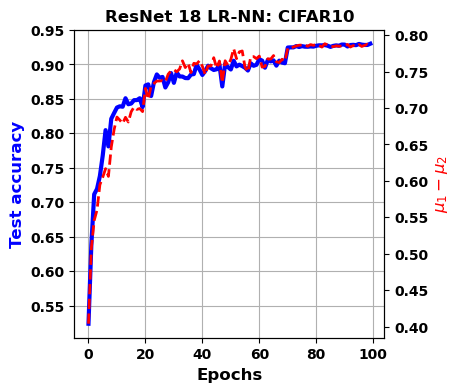

In [24]:
test_accuracy = torch.Tensor(test_accuracy)
mean_difference_all = torch.Tensor(mean_difference_all).cpu()

#for digit in range(10):

plt.figure(figsize=(4,4)) 
ax1 = plt.subplot(111)

plt.xticks(weight = 'bold')
ax1.plot(torch.arange(len(test_accuracy))[:100], test_accuracy[:100] ,color = 'blue',linewidth = 3)
plt.yticks(weight = 'bold')
ax2 = ax1.twinx()
ax2.plot(torch.arange(len(test_accuracy))[:100], mean_difference_all[:100] ,color = 'red',linewidth = 2,linestyle = '--')
ax1.set_xlabel("Epochs",fontsize = 12, fontweight = 'bold')
ax2.set_ylabel('$\mu_1-\mu_2$',fontsize = 12, color = 'red', fontweight = 'bold')
ax1.set_ylabel('Test accuracy',fontsize = 12, color = 'blue', fontweight = 'bold')
plt.yticks(weight = 'bold')
plt.title('ResNet 18 LR-NN: CIFAR10', fontsize = 12, fontweight = 'bold')
ax1.grid()
#savefig('first100_lrchange_md_resnet18lrnncifar10.pdf')

In [ ]:
with torch.no_grad():
    digit = 9
    for i, (input, target) in enumerate(valid_loader):
        input, target = input.cuda(), target.long().cuda()
    eigenvalue = torch.zeros(512).cuda()
    feature_map = model.module.feature_map(input)
    feature_map_digit = feature_map[target==digit,:].reshape(sum(target==digit),512)
    u,s,v = torch.svd(feature_map_digit-torch.mean(feature_map, dim=0))
    eigenvalue = s 
    plt.figure(figsize=(4,4))
    plt.bar(torch.arange(30),(eigenvalue[:30]/max(eigenvalue)).cpu(), color = 'orange')
    plt.title('CLass {}'.format(digit), fontsize=12)
    plt.xlabel('Index of eigens', fontsize=15)
    plt.ylabel('Eigenvalue $\lambda/\lambda_{\max}$',fontsize=15)
    plt.ylim([0,1.1])
    savefig('feature_map_correlation_{}.pdf'.format(digit))

# Saving models

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.backends.cudnn as cudnn

import model.alexnet as AlexNet
import model.resnet as ResNet
import model.vgg as Vgg
import model.lenet as LeNet
import argparse
import matplotlib.pyplot as plt
import os
import imageio
import shutil
import torch.nn.functional as F
from tensorboardX import SummaryWriter
import numpy as np
import random

def savefig(name):
    plt.savefig(name,dpi=600, bbox_inches='tight')
    return

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.benchmark = True #for accelerating the running
    return

#setup_seed(1)
device = torch.device('cuda')

parser = argparse.ArgumentParser(description='PyTorch Cifar10 Training')
parser.add_argument('--gpu-id', default=[0], nargs='+', type=int, help='available GPU IDs')
parser.add_argument('--epochs', default=250, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int, metavar='N', help='mini-batch size (default: 128),only used for train')
parser.add_argument('-w', '--workers', default=0, type=int, metavar='N', help='num_workers, at most 16, must be 0 on windows')
parser.add_argument('--lr', '--learning-rate', default=0.002, type=float, metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M', help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-3, type=float, metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('--print-freq', '-p', default=10, type=int, metavar='N', help='print frequency (default: 10)')
#parser.add_argument('--resume', default='checkpoint/Alexnet/checkpoint.pth.tar', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')
parser.add_argument('-t', '--train', dest='train', action='store_true', help='test model on test set')

args = parser.parse_known_args()[0]

Path_Name = 'Alexnet'
checkpoint_path = 'checkpoint/' + Path_Name
summary_path = 'summary/' + Path_Name
test_accuracy = []
if args.train:
    if not os.path.exists(summary_path):
        os.makedirs(summary_path)
    writer = SummaryWriter(summary_path)

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])



# CIFAR10 dataset 
train_dataset = torchvision.datasets.CIFAR10(root='data', train=True, transform=train_transform, download=True)

valid_dataset = torchvision.datasets.CIFAR10(root='data', train=False, transform=test_transform)

# valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, (int(0.5*len(test_dataset)), int(0.5*len(test_dataset))))

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=args.workers, pin_memory=True)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=args.batch_size)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)

# model = LinearNeuralNet(input_size, 5, num_classes).to(device)
#model = AlexNet.AlexNet_0()
model = ResNet.ResNet18()
model = nn.DataParallel(model, device_ids=args.gpu_id).cuda()
criterion = nn.CrossEntropyLoss().cuda()
model.load_state_dict(torch.load('resnet18cifar.pt'))
model.eval()
with torch.no_grad():
    for i, (input, target) in enumerate(valid_loader):
        input, target = input.cuda(), target.cuda().long()
        output = model(input)

        _, predicted = torch.max(output.data, 1)
        valid_total = output.shape[0]
        valid_correct = (predicted == target).sum().item()
        
        prec = valid_correct / valid_total
        test_accuracy.append(prec)
        print('Accuary on test images:{:.2f}%'.format(prec*100))
        feature_map = model.module.feature_map(input)
        torch.save(feature_map,'cifar10_feature')
        torch.save(target,'target')

        

Files already downloaded and verified


# Adversarial example

In [4]:
def linear(input):
    weight = model.state_dict()['module.linear.weight']
    output = torch.mm(input, weight.T)
    return output

def low_rank(input):
    eigen = model.state_dict()['module.linear.eigen']
    output = torch.zeros(input.shape[0],10).cuda()
    for i in range(eigen.shape[2]):
        output += (torch.mm(input, eigen[:,:,i].T))**2
    return output

def quadratic(input):
    weight_a = model.state_dict()['module.linear.weight_a']
    output = F.bilinear(input, input, weight_a)
    return output

def generate_adversial_exm_grad(varepsilon):
    adversial_exm = torch.zeros(10000,512)
    
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=1)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input.cuda(), target.cuda().long()

        feature_map = model.module.feature_map(input).data

        feature_map.requires_grad = True
        #output = linear(feature_map)
        output = quadratic(feature_map)
        #output = low_rank(feature_map)
        loss = criterion(output, target)
        loss.backward()

        adversial_exm[i:i+1,:] = feature_map + varepsilon*feature_map.grad/torch.norm(feature_map.grad)
    return adversial_exm.data


def generate_adversial_exm_sign(varepsilon):
    adversial_exm = torch.zeros(10000,512)
    
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=1)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input.cuda(), target.cuda().long()

        feature_map = model.module.feature_map(input).data

        feature_map.requires_grad = True
        #output = linear(feature_map)
        output = quadratic(feature_map)
        #output = low_rank(feature_map)
        loss = criterion(output, target)
        loss.backward()
    
        adversial_exm[i:i+1,:] = feature_map + varepsilon*torch.sign(feature_map.grad)
        
    return adversial_exm.data

test_accuracy = torch.zeros(2,10)

for j in range(10):
    adversial_input = generate_adversial_exm_grad(j*0.5)
    adversial_input_1 = generate_adversial_exm_sign(j*0.05)

    model.eval()
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=10000)
    for i, (input, target) in enumerate(valid_loader):
        input, target = input.cuda(), target.cuda().long()

    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        #output = linear(adversial_input.cuda())
        output = quadratic(adversial_input.cuda())
        #output = low_rank(adversial_input.cuda())

        _, predicted = torch.max(output.data, 1)
        valid_total = target.size(0)
        valid_correct = (predicted == target).sum().item()



    prec = valid_correct / valid_total
    print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec*100, j*0.5))

    valid_correct = 0
    valid_total = 0
    with torch.no_grad():
        #output = linear(adversial_input_1.cuda())
        output = quadratic(adversial_input_1.cuda())
        #output = low_rank(adversial_input_1.cuda())

        _, predicted = torch.max(output.data, 1)
        valid_total = target.size(0)
        valid_correct = (predicted == target).sum().item()


    prec_1 = valid_correct / valid_total
    print('Accuary on test images:{:.2f}%, epsilon:{}'.format(prec_1*100, j*0.05))
    test_accuracy[0,j] = prec # gradient ad
    test_accuracy[1,j] = prec_1 #sign ad

KeyError: 'module.linear.weight'

# KS distance

In [ ]:
test_accuracy = torch.Tensor(test_accuracy)
KS_dis = torch.Tensor(KS_dis)

for digit in range(10):
    fig = plt.figure() 
    ax1 = fig.add_subplot(111)

    ax1.plot(torch.arange(250), test_accuracy[torch.arange(2500)%10==digit] ,color = 'blue',linewidth = 5)
    ax2 = ax1.twinx()
    ax2.plot(torch.arange(250), KS_dis[torch.arange(2500)%10==digit] ,color = 'red', linewidth = 3, linestyle = '--')
    ax1.set_xlabel("Epoch",fontsize = 20)
    ax2.set_ylabel('KS distance',fontsize = 20, color = 'red')
    ax1.set_ylabel('Test Accuracy',fontsize = 20, color = 'blue')
    plt.title('Class {}'.format(digit), fontsize = 20)
    savefig('linear_KS_cifar10_two_norm_{}.svg'.format(digit))